In [3]:
from sism.datasets import generate_concentric_circle_dataset, generate_c4_gmm_dataset, generate_mog_2d
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import math
from IPython.display import display, clear_output

In [4]:
import torch
import torch.nn as nn

In [5]:
from torch.func import jacrev, vmap

In [4]:
in_dim = 2
hidden_dim = 32
network = nn.Sequential(nn.Linear(in_dim, hidden_dim),
                        nn.SiLU(), 
                        nn.Linear(hidden_dim, hidden_dim),
                        nn.SiLU(), 
                        nn.Linear(hidden_dim, in_dim),
                        )

In [5]:
dataset = generate_concentric_circle_dataset(nsamples=10_000, r0=4.0, r1=8.0, both=False)

In [6]:
figsize = (6, 6)

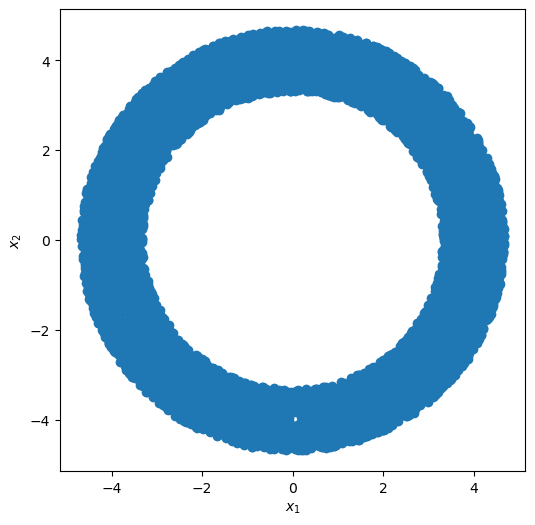

In [7]:
plt.figure(figsize=figsize)
plt.scatter(dataset[:, 0], dataset[:, 1])
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.show()

In [8]:
x = torch.from_numpy(dataset)
bs = 128
ids = np.arange(len(dataset))
torch_dataset = x.clone()

In [9]:
def model_foward(x):
    y = network(x)
    return y
def compute_model_forward_jacobian_ft(x):
    y = model_foward(x)
    return y, y

In [10]:
def compute_model_forward_jacobian(x, model):
    y = model(x)
    out_dim = y.size(-1)
    dydx = torch.tensor([], dtype=x.dtype, device=x.device)
    for i in range(out_dim):
        l = torch.zeros_like(y)
        l[:, i] = 1.
        d = torch.autograd.grad(y, x, retain_graph=True, create_graph=True, grad_outputs=l)[0]  #d: (batch_size, input_dim)
        dydx = torch.concat((dydx, d.unsqueeze(dim=1)), dim=1)  #dydx: (batch_size, , output_dim, input_dim)
    return dydx, y

In [11]:
def compute_divergence(jacobian):
    # in 2d: (jacobian[:, 0, 0] + jacobian[:, 1, 1])
    return jacobian.diagonal(offset=0, dim1=-2, dim2=-1).sum(dim=-1)

def L_r(x, J):
    # x: (B, 2)
    # J (B, 2, 2)
    score = x[:, 0] * J[:, 0, 0] + x[:, 1] * J[:, 0, 1]
    return score

def L_phi(x, J):
    # x: (B, 2)
    # J (B, 2, 2)
    score = x[:, 1] * J[:, 1, 0] - x[:, 0] * J[:, 1, 1]
    return score


In [12]:
x.requires_grad = True
jacobian, y = vmap(jacrev(func=compute_model_forward_jacobian_ft, has_aux=True))(x)

In [13]:
jacobian_old, y_old = compute_model_forward_jacobian(x, network)

In [14]:
print(torch.norm(jacobian-jacobian_old))

tensor(1.7927e-06, grad_fn=<LinalgVectorNormBackward0>)


In [15]:
print(torch.norm(y - y_old))

tensor(5.2139e-06, grad_fn=<LinalgVectorNormBackward0>)


## Fisher Score Matching

Operator $L=\nabla = (\frac{\partial}{\partial x_1}, \frac{\partial}{\partial x_2})$ with loss
as 
$$
D_F(p || q_\theta) = \int _x p(x) [ || s_\theta(x_1, x_2)||^2  + 2 \sum_{i=1}^2 \frac{\partial}{\partial x_i} \frac{\partial}{\partial x_i} s(x_1, x_2)] 
$$

  0%|          | 0/500 [00:00<?, ?it/s]

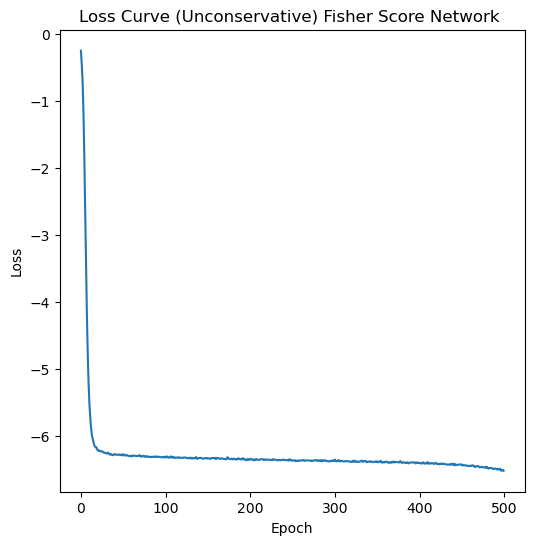

In [16]:
in_dim = 2
hidden_dim = 32
fisher_score_net = nn.Sequential(nn.Linear(in_dim, hidden_dim),
                        nn.SiLU(), 
                        nn.Linear(hidden_dim, hidden_dim),
                        nn.SiLU(), 
                        nn.Linear(hidden_dim, in_dim),
                        )


optimizer_grad = torch.optim.Adam(fisher_score_net.parameters(), lr=4e-4)
epoch_losses = []
for epoch in tqdm(range(500)):
    epoch_loss = 0.0
    np.random.shuffle(ids)
    split = np.array_split(ids, math.ceil(len(ids) / bs))
    for i, idx in enumerate(split):
        optimizer_grad.zero_grad()
        xin = torch_dataset[idx]
        xin.requires_grad_()
        J, score = compute_model_forward_jacobian(xin, model=fisher_score_net)
        loss = score.pow(2).sum(-1).mean() + 2.0 * compute_divergence(J).mean()
        loss.backward()
        optimizer_grad.step()

        epoch_loss += loss.item()
    
    epoch_loss /= len(split)
    
    epoch_losses.append(epoch_loss)
    
plt.figure(figsize=figsize)

plt.plot(range(len(epoch_losses)), epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve (Unconservative) Fisher Score Network ")
plt.show()

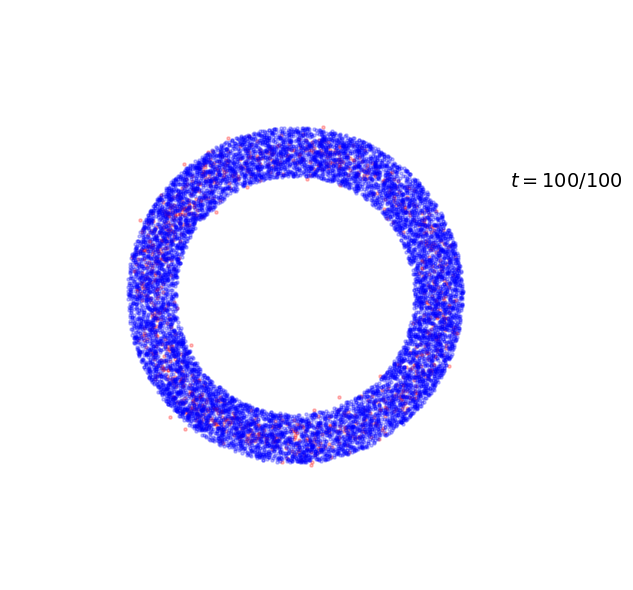

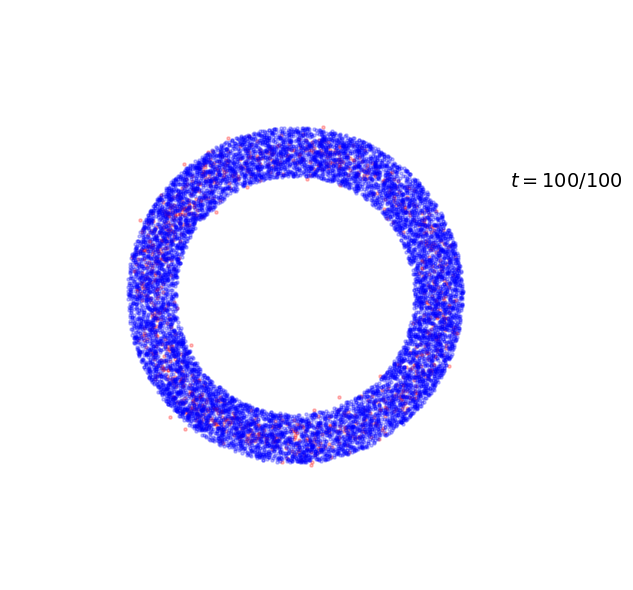

In [17]:
num_samples = 1000
T = 100
chain = np.arange(T)

xsampled = torch.randn(num_samples, in_dim) * 1.0
x_traj = []
xnumpy = x.detach().cpu()
fig, ax = plt.subplots(figsize=figsize)
scatter_plot = ax.scatter(xsampled.detach().cpu()[:, 0],
                          xsampled.detach().cpu()[:, 1],
                          s=5, alpha=0.25, color="red", label="generated")
true_plot = ax.scatter(xnumpy[:, 0],
                      xnumpy[:, 1],
                      s=5, alpha=0.25, color="blue", label="true")

time_text = ax.text(6.0, 3.0, '$t=0$', fontsize=14)
ax.axis('equal')
ax.set_xlim(-8.0, 8.0)
ax.set_ylim(-8.0, 8.0)
ax.axis("off") # remove the axis will speed up the training
fig.tight_layout()
clear_output(wait=True)
display(fig)

eps = 1e-2

with torch.no_grad():
    for i, t in tqdm(enumerate(chain), total=T):
        score = fisher_score_net(xsampled)
        xsampled = xsampled + eps * score + math.sqrt(eps) * torch.randn_like(xsampled)
        # xsampled = xsampled + eps * score # + math.sqrt(eps) * torch.randn_like(xsampled)
        
        x_traj.append(xsampled)        
        time_text.set_text(f'$t={i+1} / {T}$')
        scatter_plot.set_offsets(xsampled.cpu().detach().numpy())
        x_traj.append(xsampled)
        clear_output(wait=True)
        display(fig)

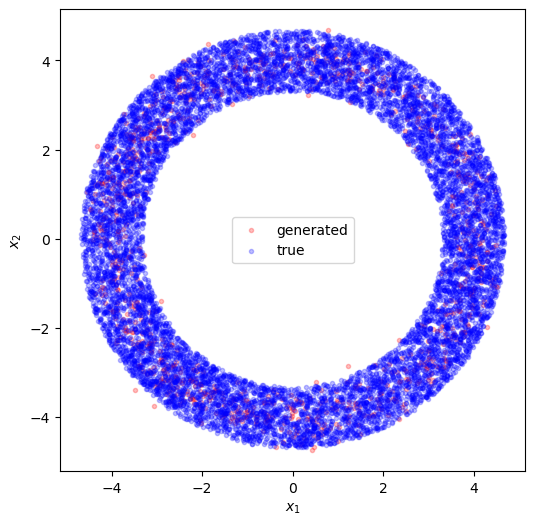

In [18]:
xsampled = xsampled.detach().cpu()
x = x.detach().cpu()
plt.figure(figsize=figsize)
plt.scatter(xsampled[:, 0].numpy(), xsampled[:, 1].numpy(), marker=".", color="red", label="generated", alpha=0.25)
plt.scatter(x[:, 0].numpy(), x[:, 1].numpy(), marker=".", color="blue", label="true", alpha=0.25)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

/Users/marcobertolini/miniconda3/envs/sism/lib/python3.11/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1724788636145/work/aten/src/ATen/native/TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


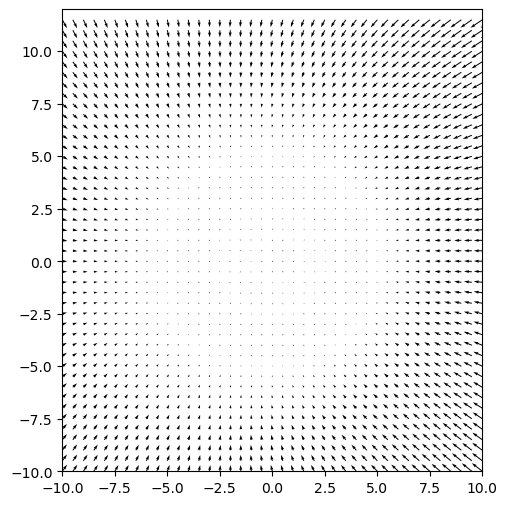

In [19]:

# Creating arrow
grid_x = torch.arange(-10, 12, 0.5)
grid_y = torch.arange(-10, 12, 0.5)
X, Y = torch.meshgrid(grid_x, grid_y)
x_grid = torch.stack([torch.flatten(X), torch.flatten(Y)], dim=1)
with torch.no_grad():
    s = fisher_score_net(x_grid)
# creating plot
fig, ax = plt.subplots(figsize =figsize)
ax.quiver(x_grid[:, 0], x_grid[:, 1], s[:, 0], s[:, 1])
ax.axis([-10, 10, -10, 12])
ax.set_aspect('equal')
# show plot
plt.show()

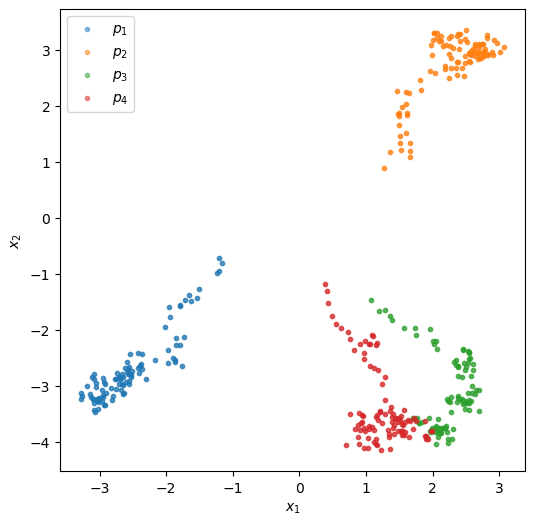

In [20]:
traj_1 = torch.stack(x_traj)[:, 1, :].detach()
traj_2 = torch.stack(x_traj)[:, 2, :].detach()
traj_3 = torch.stack(x_traj)[:, 3, :].detach()
traj_4 = torch.stack(x_traj)[:, 4, :].detach()

plt.figure(figsize=figsize)
plt.scatter(traj_1[:, 0], traj_1[:, 1], marker=".", alpha=0.5, label=r'$p_1$')
plt.scatter(traj_2[:, 0], traj_2[:, 1], marker=".", alpha=0.5, label=r'$p_2$')
plt.scatter(traj_3[:, 0], traj_3[:, 1], marker=".", alpha=0.5, label=r'$p_3$')
plt.scatter(traj_4[:, 0], traj_4[:, 1], marker=".", alpha=0.5, label=r'$p_4$')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

## Generalized Score Matching
Operator $L=\nabla = (L_r,L_\phi)$ with $L_r =x_1 \frac{\partial}{\partial x_1} + x_2 \frac{\partial}{\partial x_2}$ and $L_\phi =x_2 \frac{\partial}{\partial x_1}- x_1 \frac{\partial}{\partial x_2}  $


$$
D_F(p || q_\theta) = \int _x p(x) [ ||s(x_1, x_2))||^2  + 2 (L_r s(x_1, x_2)_r + L_1 s(x_1, x_2)_\phi ) + 2s(x_1, x_2)_r] 
$$

  0%|          | 0/500 [00:00<?, ?it/s]

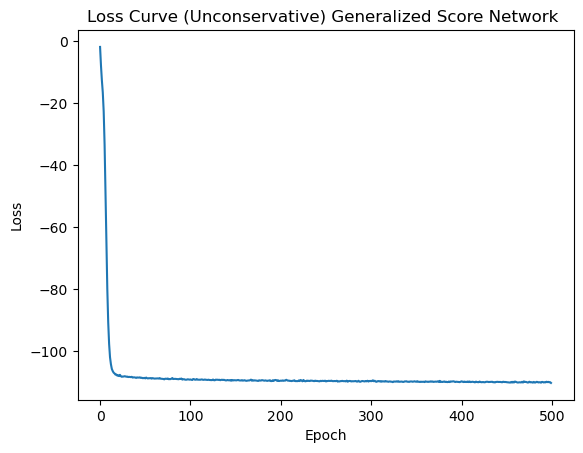

In [21]:
general_score_net = nn.Sequential(nn.Linear(in_dim, hidden_dim),
                        nn.SiLU(), 
                        nn.Linear(hidden_dim, hidden_dim),
                        nn.SiLU(), 
                        nn.Linear(hidden_dim, in_dim),
                        )
optimizer_L = torch.optim.Adam(general_score_net.parameters(), lr=4e-4)

epoch_losses = []
for epoch in tqdm(range(500)):
    epoch_loss = 0.0
    np.random.shuffle(ids)
    split = np.array_split(ids, math.ceil(len(ids) / bs))
    for i, idx in enumerate(split):
        optimizer_L.zero_grad()
        xin = torch_dataset[idx]
        xin.requires_grad_()        
        J, score = compute_model_forward_jacobian(xin, model=general_score_net)  
        scorenorm = score.pow(2).sum(-1).mean()
        lr = L_r(xin, J).mean()
        lphi = L_phi(xin, J).mean()
        srsq = (2 * score[:, 0]).mean()
        loss = scorenorm + 2 * (lr + lphi + srsq)
        loss.backward()
        optimizer_L.step()
        
        epoch_loss += loss.item()
    
    epoch_loss /= len(split)
    
    epoch_losses.append(epoch_loss)
    
plt.plot(figsize=figsize)
plt.plot(range(len(epoch_losses)), epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve (Unconservative) Generalized Score Network ")
plt.show()

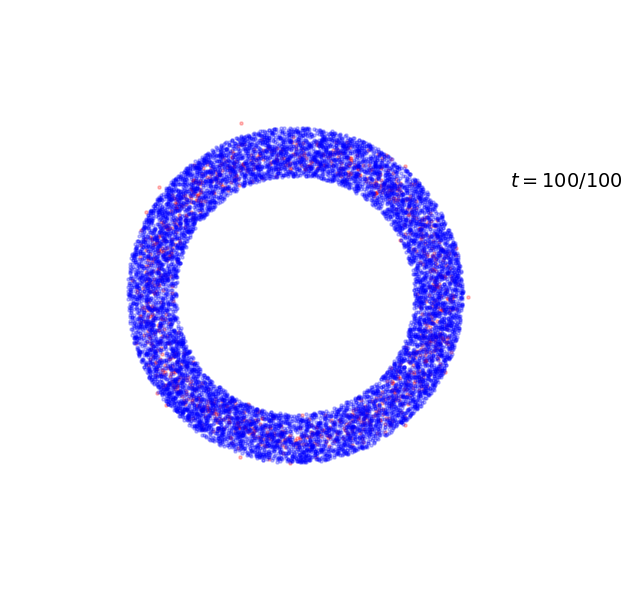

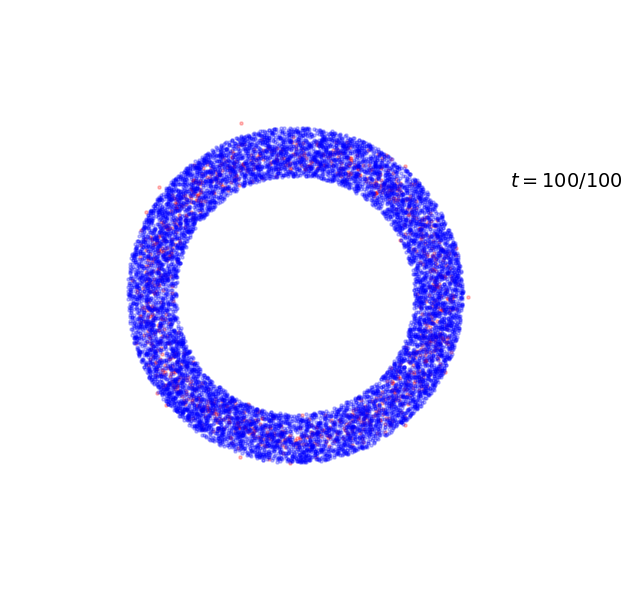

In [22]:
num_samples = 1000
T = 100
chain = np.arange(T)

xsampled = torch.randn(num_samples, in_dim) * 1.0
x_traj = []

xnumpy = x.detach().cpu()
fig, ax = plt.subplots(figsize=figsize)
scatter_plot = ax.scatter(xsampled.detach().cpu()[:, 0],
                          xsampled.detach().cpu()[:, 1],
                          s=5, alpha=0.25, color="red", label="generated")
true_plot = ax.scatter(xnumpy[:, 0],
                      xnumpy[:, 1],
                      s=5, alpha=0.25, color="blue", label="true")

time_text = ax.text(6.0, 3.0, '$t=0$', fontsize=14)
ax.axis('equal')
ax.set_xlim(-8.0, 8.0)
ax.set_ylim(-8.0, 8.0)
ax.axis("off") # remove the axis will speed up the training
fig.tight_layout()
clear_output(wait=True)
display(fig)

# 1e-2 converges faster
eps0 = 1 * 1e-3
eps1 = 1 * 1e-3
eps = [eps0, eps1]

# x (B, 2)
# M (B, 2, 2)

with torch.no_grad():
    for i, t in tqdm(enumerate(chain), total=T):
        score = general_score_net(xsampled)
        
        M = torch.stack([score, score.flip(-1)], dim=-1)
        M[:, 1, 0] = -1.0 * M[:, 1, 0] 
        Z = torch.randn_like(xsampled)
        Z = torch.stack([Z, Z.flip(-1)], dim=-1)
        Z[:, 1, 0] = -1.0 * Z[:, 1, 0] 
        M = eps0 * M + math.sqrt(eps0) * Z
        shift = torch.einsum('bij, bj -> bi', (M, xsampled))
        xsampled = xsampled + shift
        x_traj.append(xsampled)        
        time_text.set_text(f'$t={i+1} / {T}$')
        scatter_plot.set_offsets(xsampled.cpu().detach().numpy())
        x_traj.append(xsampled)
        clear_output(wait=True)
        display(fig)

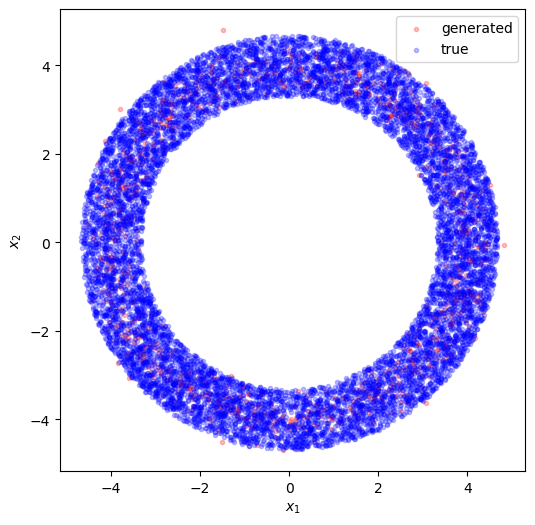

In [23]:
xsampled = xsampled.detach().cpu()
x = x.detach().cpu()
plt.figure(figsize=figsize)
plt.scatter(xsampled[:, 0].numpy(), xsampled[:, 1].numpy(), marker=".", color="red", label="generated", alpha=0.25)
plt.scatter(x[:, 0].numpy(), x[:, 1].numpy(), marker=".", color="blue", label="true", alpha=0.25)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

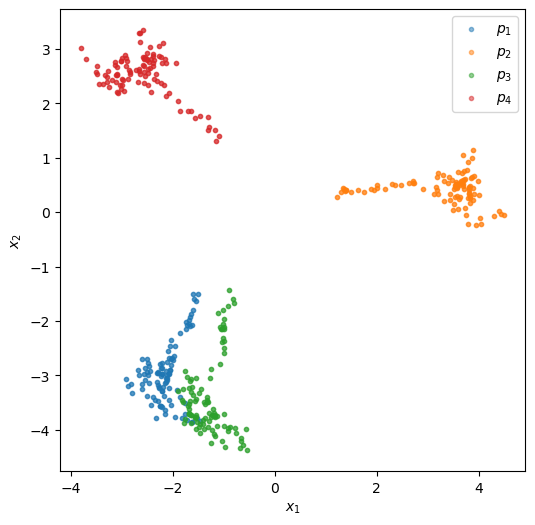

In [24]:
traj_1 = torch.stack(x_traj)[:, 1, :].detach()
traj_2 = torch.stack(x_traj)[:, 2, :].detach()
traj_3 = torch.stack(x_traj)[:, 3, :].detach()
traj_4 = torch.stack(x_traj)[:, 4, :].detach()

plt.figure(figsize=figsize)
plt.scatter(traj_1[:, 0], traj_1[:, 1], marker=".", alpha=0.5, label=r'$p_1$')
plt.scatter(traj_2[:, 0], traj_2[:, 1], marker=".", alpha=0.5, label=r'$p_2$')
plt.scatter(traj_3[:, 0], traj_3[:, 1], marker=".", alpha=0.5, label=r'$p_3$')
plt.scatter(traj_4[:, 0], traj_4[:, 1], marker=".", alpha=0.5, label=r'$p_4$')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

## Gaussian C4

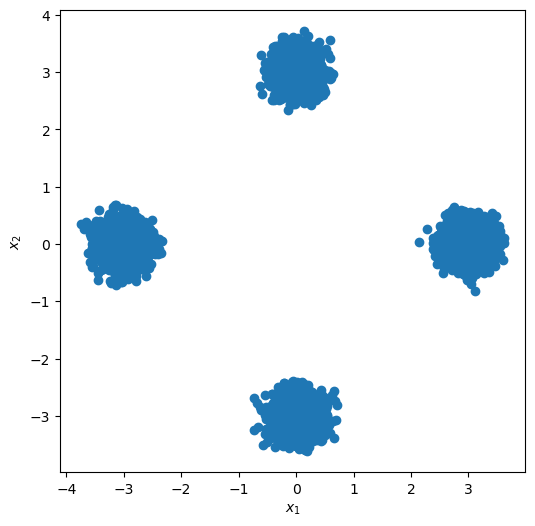

In [25]:
dataset = generate_c4_gmm_dataset(nsamples=10_000)
x = dataset.clone()
bs = 128
x = dataset.clone()
ids = np.arange(len(dataset))
torch_dataset = x.clone()

plt.figure(figsize=figsize)
plt.scatter(dataset[:, 0], dataset[:, 1])
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

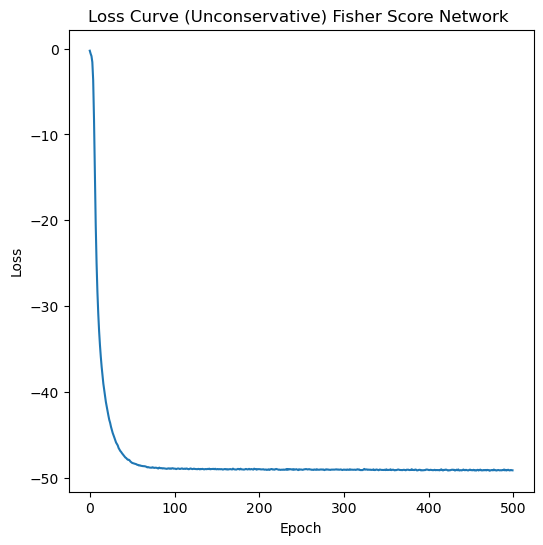

In [26]:
in_dim = 2
hidden_dim = 32
fisher_score_net = nn.Sequential(nn.Linear(in_dim, hidden_dim),
                        nn.SiLU(), 
                        nn.Linear(hidden_dim, hidden_dim),
                        nn.SiLU(), 
                        nn.Linear(hidden_dim, in_dim),
                        )


optimizer_grad = torch.optim.Adam(fisher_score_net.parameters(), lr=4e-4)

epoch_losses = []
for epoch in tqdm(range(500)):
    epoch_loss = 0.0
    np.random.shuffle(ids)
    split = np.array_split(ids, math.ceil(len(ids) / bs))
    for i, idx in enumerate(split):
        optimizer_grad.zero_grad()
        xin = torch_dataset[idx]
        xin.requires_grad_()
        J, score = compute_model_forward_jacobian(xin, model=fisher_score_net)
        loss = score.pow(2).sum(-1).mean() + 2.0 * compute_divergence(J).mean()
        loss.backward()
        optimizer_grad.step()

        epoch_loss += loss.item()
    
    epoch_loss /= len(split)
    
    epoch_losses.append(epoch_loss)
    
plt.figure(figsize=figsize)

plt.plot(range(len(epoch_losses)), epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve (Unconservative) Fisher Score Network ")
plt.show()

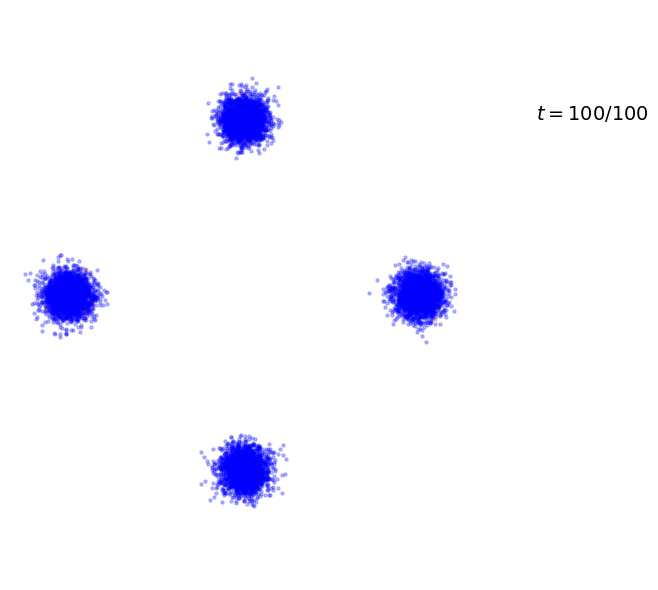

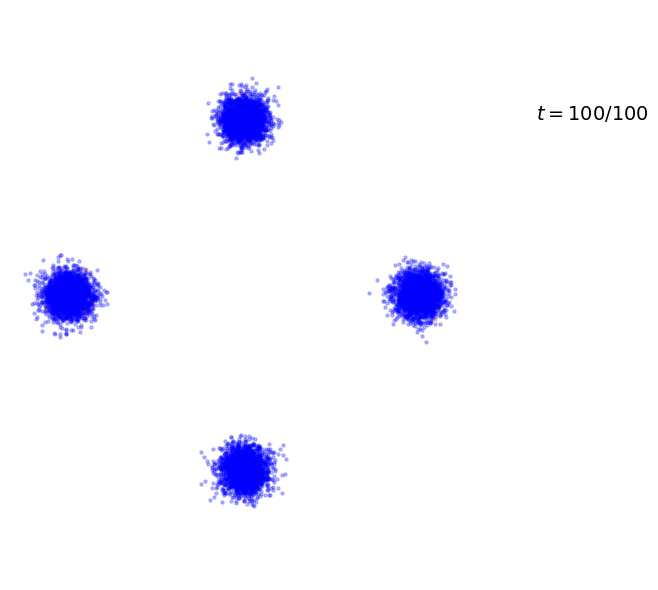

In [27]:
num_samples = 1000
T = 100
chain = np.arange(T)

xsampled = torch.randn(num_samples, in_dim) * 1.0
x_traj = []
xnumpy = x.detach().cpu()
fig, ax = plt.subplots(figsize=figsize)
scatter_plot = ax.scatter(xsampled.detach().cpu()[:, 0],
                          xsampled.detach().cpu()[:, 1],
                          s=5, alpha=0.25, color='red', label="generated")
true_plot = ax.scatter(xnumpy[:, 0],
                      xnumpy[:, 1],
                      s=5, alpha=0.25, color='blue', label="true")

time_text = ax.text(5.0, 3.0, '$t=0$', fontsize=14)
ax.axis('equal')
ax.set_xlim(-4.0, 4.0)
ax.set_ylim(-4.0, 4.0)
ax.axis("off") # remove the axis will speed up the training
fig.tight_layout()
clear_output(wait=True)
display(fig)

eps = 1e-2

with torch.no_grad():
    for i, t in tqdm(enumerate(chain), total=T):
        score = fisher_score_net(xsampled)
        xsampled = xsampled + eps * score + math.sqrt(eps) * torch.randn_like(xsampled)
        x_traj.append(xsampled)        
        time_text.set_text(f'$t={i+1} / {T}$')
        scatter_plot.set_offsets(xsampled.cpu().detach().numpy())
        x_traj.append(xsampled)
        clear_output(wait=True)
        display(fig)

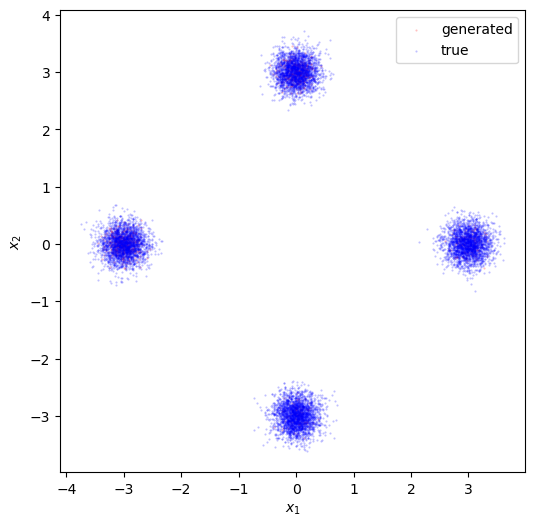

In [28]:
xsampled = xsampled.detach().cpu()
x = x.detach().cpu()
plt.figure(figsize=figsize)
plt.scatter(xsampled[:, 0].numpy(), xsampled[:, 1].numpy(), marker=".", color="red", label="generated", s=1, alpha=0.25)
plt.scatter(x[:, 0].numpy(), x[:, 1].numpy(), marker=".", color="blue", label="true", s=1, alpha=0.25)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

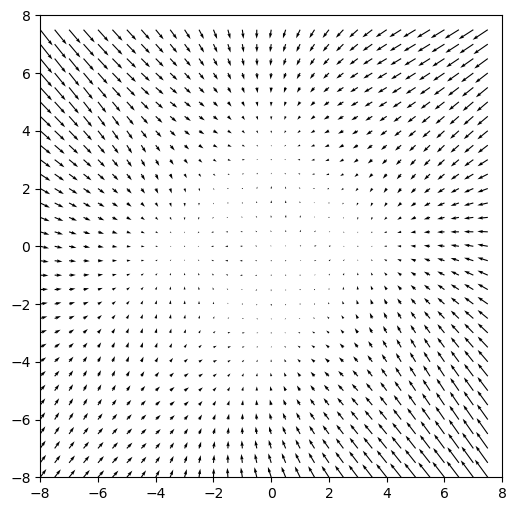

In [29]:
# Creating arrow
grid_x = torch.arange(-8, 8, 0.5)
grid_y = torch.arange(-8, 8, 0.5)
X, Y = torch.meshgrid(grid_x, grid_y)
x_grid = torch.stack([torch.flatten(X), torch.flatten(Y)], dim=1)
with torch.no_grad():
    s = fisher_score_net(x_grid)
# creating plot
fig, ax = plt.subplots(figsize =figsize)
ax.quiver(x_grid[:, 0], x_grid[:, 1], s[:, 0], s[:, 1])
ax.axis([-8, 8, -8, 8])
ax.set_aspect('equal')
# show plot
plt.show()

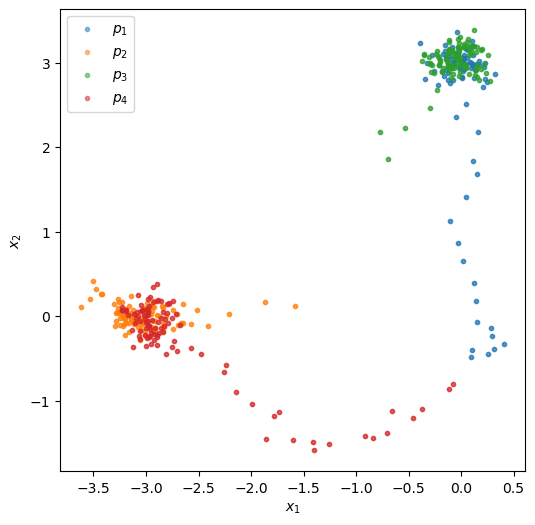

In [30]:
traj_1 = torch.stack(x_traj)[:, 1, :].detach()
traj_2 = torch.stack(x_traj)[:, 2, :].detach()
traj_3 = torch.stack(x_traj)[:, 3, :].detach()
traj_4 = torch.stack(x_traj)[:, 4, :].detach()

plt.figure(figsize=figsize)
plt.scatter(traj_1[:, 0], traj_1[:, 1], marker=".", alpha=0.5, label=r'$p_1$')
plt.scatter(traj_2[:, 0], traj_2[:, 1], marker=".", alpha=0.5, label=r'$p_2$')
plt.scatter(traj_3[:, 0], traj_3[:, 1], marker=".", alpha=0.5, label=r'$p_3$')
plt.scatter(traj_4[:, 0], traj_4[:, 1], marker=".", alpha=0.5, label=r'$p_4$')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

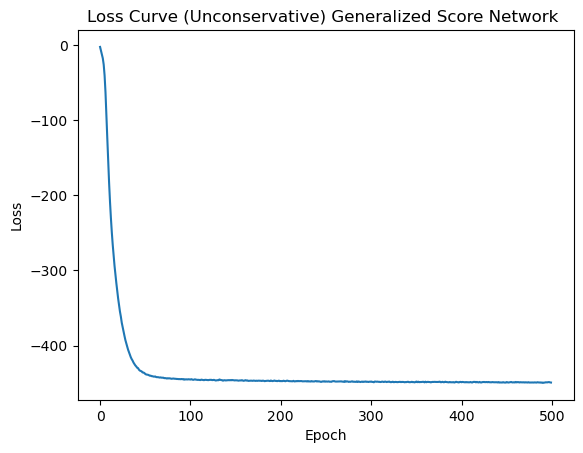

In [31]:
general_score_net = nn.Sequential(nn.Linear(in_dim, hidden_dim),
                        nn.SiLU(), 
                        nn.Linear(hidden_dim, hidden_dim),
                        nn.SiLU(), 
                        nn.Linear(hidden_dim, in_dim),
                        )
optimizer_L = torch.optim.Adam(general_score_net.parameters(), lr=4e-4)

epoch_losses = []
for epoch in tqdm(range(500)):
    epoch_loss = 0.0
    np.random.shuffle(ids)
    split = np.array_split(ids, math.ceil(len(ids) / bs))
    for i, idx in enumerate(split):
        optimizer_L.zero_grad()
        xin = torch_dataset[idx]
        xin.requires_grad_()        
        J, score = compute_model_forward_jacobian(xin, model=general_score_net)  
        scorenorm = score.pow(2).sum(-1).mean()
        lr = L_r(xin, J).mean()
        lphi = L_phi(xin, J).mean()
        srsq = (2 * score[:, 0]).mean()
        loss = scorenorm + 2 * (lr + lphi + srsq)
        loss.backward()
        optimizer_L.step()
        
        epoch_loss += loss.item()
    
    epoch_loss /= len(split)
    
    epoch_losses.append(epoch_loss)
    
plt.plot(figsize=figsize)
plt.plot(range(len(epoch_losses)), epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve (Unconservative) Generalized Score Network ")
plt.show()

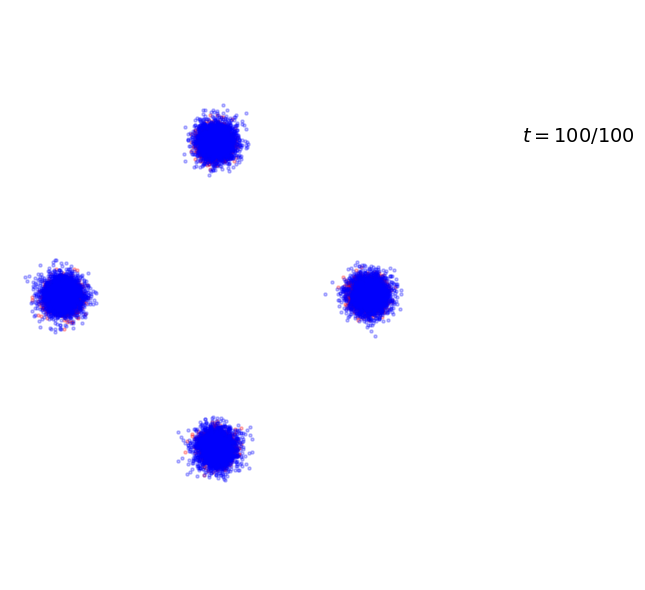

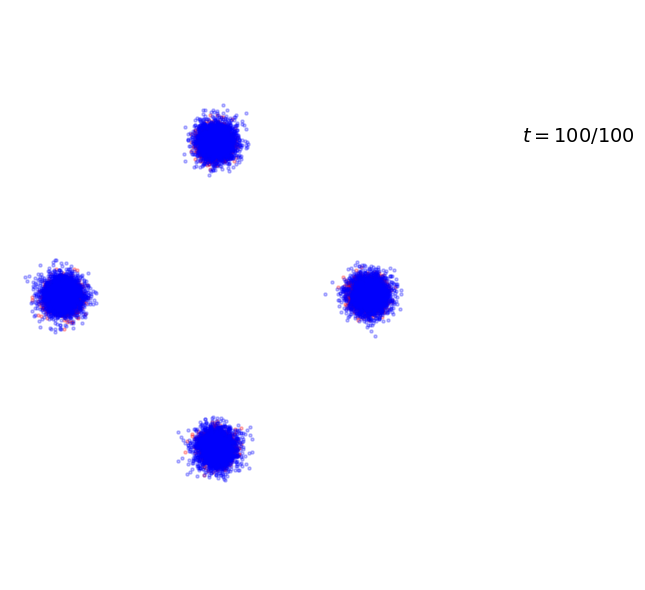

In [34]:
num_samples = 10000
T = 100
chain = np.arange(T)

xsampled = torch.randn(num_samples, in_dim) * 1.0
x_traj = []

xnumpy = x.detach().cpu()
fig, ax = plt.subplots(figsize=figsize)
scatter_plot = ax.scatter(xsampled.detach().cpu()[:, 0],
                          xsampled.detach().cpu()[:, 1],
                          s=5, alpha=0.25, color='red', label="generated")
true_plot = ax.scatter(xnumpy[:, 0],
                      xnumpy[:, 1],
                      s=5, alpha=0.25, color='blue', label="true")

time_text = ax.text(6.0, 3.0, '$t=0$', fontsize=14)
ax.axis('equal')
ax.set_xlim(-4.0, 4.0)
ax.set_ylim(-4.0, 4.0)
ax.axis("off") # remove the axis will speed up the training
fig.tight_layout()
clear_output(wait=True)
display(fig)

# 1e-2 converges faster
eps0 = 1e-3
eps1 = 1e-3

with torch.no_grad():
    for i, t in tqdm(enumerate(chain), total=T):
        score = general_score_net(xsampled)
        
        M = torch.stack([score, score.flip(-1)], dim=-1)
        M[:, 1, 0] = -1.0 * M[:, 1, 0] 
        Z = torch.randn_like(xsampled)
        Z = torch.stack([Z, Z.flip(-1)], dim=-1)
        Z[:, 1, 0] = -1.0 * Z[:, 1, 0] 
        M = eps0 * M + math.sqrt(eps0) * Z
        shift = torch.einsum('bij, bj -> bi', (M, xsampled))
        xsampled = xsampled + shift
        
        x_traj.append(xsampled)        
        time_text.set_text(f'$t={i+1} / {T}$')
        scatter_plot.set_offsets(xsampled.cpu().detach().numpy())
        x_traj.append(xsampled)
        clear_output(wait=True)
        display(fig)

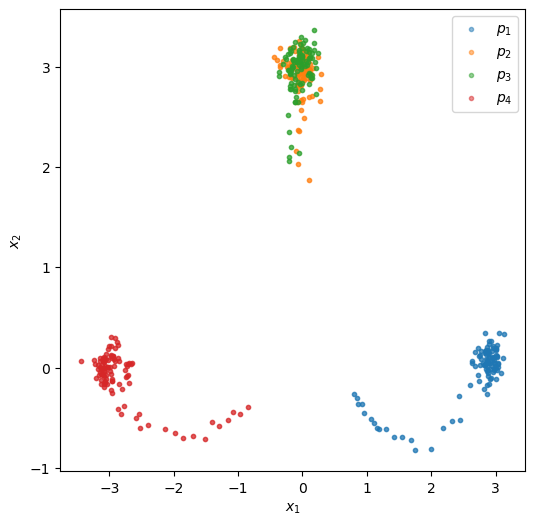

In [33]:
traj_1 = torch.stack(x_traj)[:, 1, :].detach()
traj_2 = torch.stack(x_traj)[:, 2, :].detach()
traj_3 = torch.stack(x_traj)[:, 3, :].detach()
traj_4 = torch.stack(x_traj)[:, 4, :].detach()

plt.figure(figsize=figsize)
plt.scatter(traj_1[:, 0], traj_1[:, 1], marker=".", alpha=0.5, label=r'$p_1$')
plt.scatter(traj_2[:, 0], traj_2[:, 1], marker=".", alpha=0.5, label=r'$p_2$')
plt.scatter(traj_3[:, 0], traj_3[:, 1], marker=".", alpha=0.5, label=r'$p_3$')
plt.scatter(traj_4[:, 0], traj_4[:, 1], marker=".", alpha=0.5, label=r'$p_4$')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

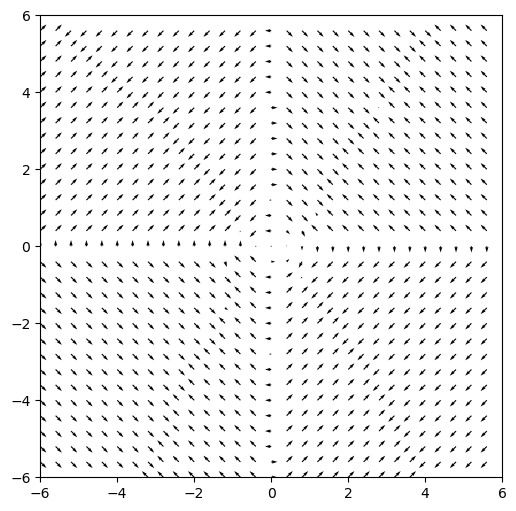

In [53]:
# Creating arrow
grid_x = torch.arange(-6, 6, 0.4)
grid_y = torch.arange(-6, 6, 0.4)
X, Y = torch.meshgrid(grid_x, grid_y)
x_grid = torch.stack([torch.flatten(X), torch.flatten(Y)], dim=1)
with torch.no_grad():
    s = general_score_net(x_grid)
# creating plot
# sr = torch.mul(torch.stack([s[:, 1], s[:, 1]],).T, x_grid)
x_grid2 = torch.stack([-torch.flatten(Y), torch.flatten(X)], dim=1)
s2 = torch.clamp((torch.mul(torch.stack([s[:, 1], s[:, 1]],).T, x_grid2).T ).T, min=-1, max=1)
fig, ax = plt.subplots(figsize =figsize)
# ax.quiver(x_grid[:, 0], x_grid[:, 1], sr[:, 0], sr[:, 1])
ax.quiver(x_grid[:, 0], x_grid[:, 1], s2[:, 0], s2[:, 1])
ax.axis([-6, 6, -6, 6])
ax.set_aspect('equal')
# show plot
plt.show()

## General 2d distribution through MoG

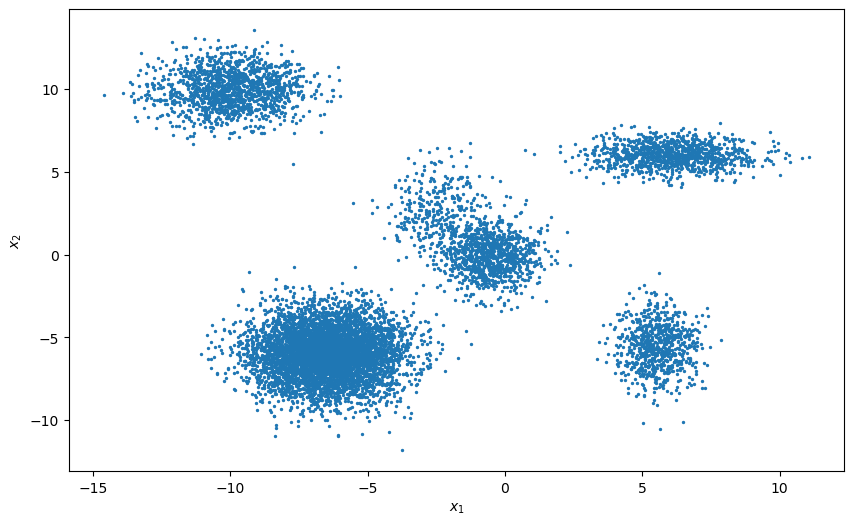

In [54]:
dataset = generate_mog_2d(nsamples=10_000)
bs = 128
x = dataset.clone()
ids = np.arange(len(dataset))
torch_dataset = x.clone()
plt.figure(figsize=(10, 6))
plt.scatter(dataset[:, 0], dataset[:, 1], s=2,)
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

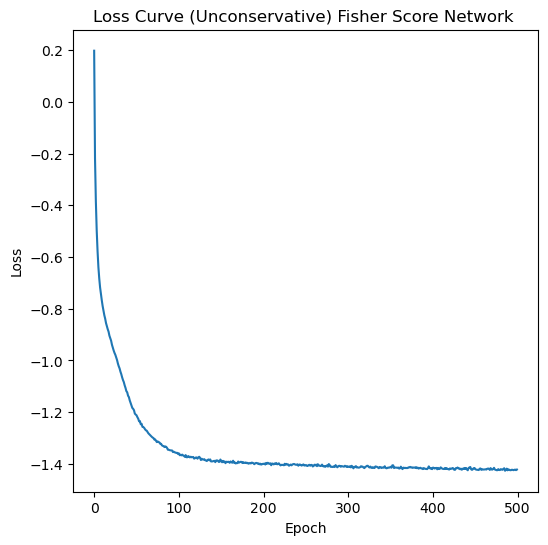

In [55]:
in_dim = 2
hidden_dim = 32
fisher_score_net = nn.Sequential(nn.Linear(in_dim, hidden_dim),
                        nn.SiLU(), 
                        nn.Linear(hidden_dim, hidden_dim),
                        nn.SiLU(), 
                        nn.Linear(hidden_dim, in_dim),
                        )


optimizer_grad = torch.optim.Adam(fisher_score_net.parameters(), lr=4e-4)

epoch_losses = []
for epoch in tqdm(range(500)):
    epoch_loss = 0.0
    np.random.shuffle(ids)
    split = np.array_split(ids, math.ceil(len(ids) / bs))
    for i, idx in enumerate(split):
        optimizer_grad.zero_grad()
        xin = torch_dataset[idx]
        xin.requires_grad_()
        J, score = compute_model_forward_jacobian(xin, model=fisher_score_net)
        loss = score.pow(2).sum(-1).mean() + 2.0 * compute_divergence(J).mean()
        loss.backward()
        optimizer_grad.step()

        epoch_loss += loss.item()
    
    epoch_loss /= len(split)
    
    epoch_losses.append(epoch_loss)
    
plt.figure(figsize=figsize)

plt.plot(range(len(epoch_losses)), epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve (Unconservative) Fisher Score Network ")
plt.show()

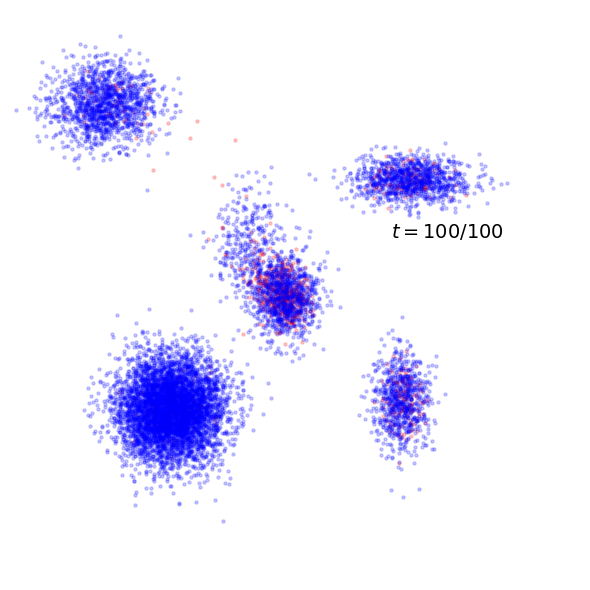

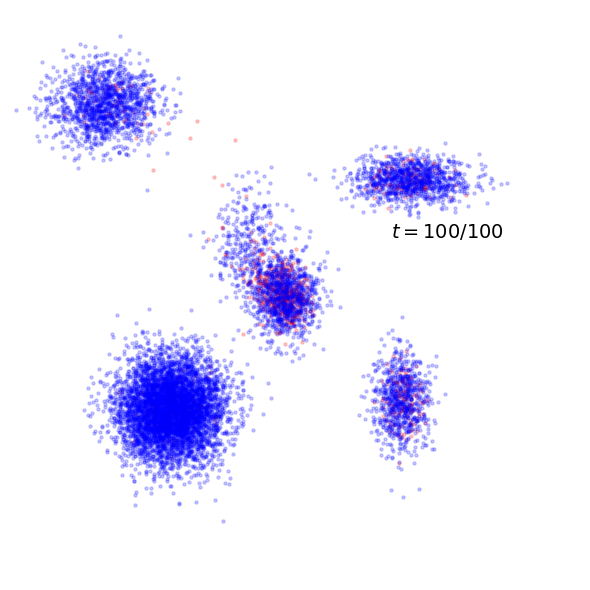

In [56]:
num_samples = 1000
T = 100
chain = np.arange(T)

xsampled = torch.randn(num_samples, in_dim) * 4.0
x_traj = []
xnumpy = x.detach().cpu()
fig, ax = plt.subplots(figsize=figsize)
scatter_plot = ax.scatter(xsampled.detach().cpu()[:, 0],
                          xsampled.detach().cpu()[:, 1],
                          s=5, alpha=0.2, color='red', label="generated")
true_plot = ax.scatter(xnumpy[:, 0],
                      xnumpy[:, 1],
                      s=5, alpha=0.2, color='blue', label="true")

time_text = ax.text(5.0, 3.0, '$t=0$', fontsize=14)
ax.axis('equal')
ax.set_xlim(-15.0, 15.0)
ax.set_ylim(-15.0, 15.0)
ax.axis("off") # remove the axis will speed up the training
fig.tight_layout()
clear_output(wait=True)
display(fig)

eps = 1 * 1e-1

with torch.no_grad():
    for i, t in tqdm(enumerate(chain), total=T):
        score = fisher_score_net(xsampled)
        xsampled = xsampled + eps * score + math.sqrt(eps) * torch.randn_like(xsampled)
        x_traj.append(xsampled)        
        time_text.set_text(f'$t={i+1} / {T}$')
        scatter_plot.set_offsets(xsampled.cpu().detach().numpy())
        x_traj.append(xsampled)
        clear_output(wait=True)
        display(fig)

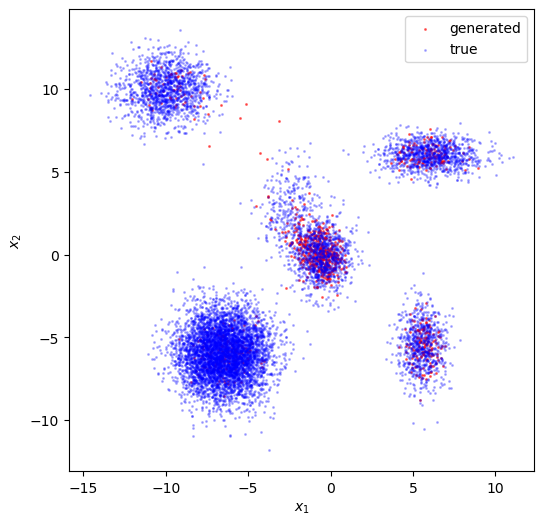

In [57]:
xsampled = xsampled.detach().cpu()
x = x.detach().cpu()
plt.figure(figsize=figsize)
plt.scatter(xsampled[:, 0].numpy(), xsampled[:, 1].numpy(), marker=".", color="red", label="generated", s=5, alpha=0.5)
plt.scatter(x[:, 0].numpy(), x[:, 1].numpy(), marker=".", color="blue", label="true", s=5, alpha=0.25)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

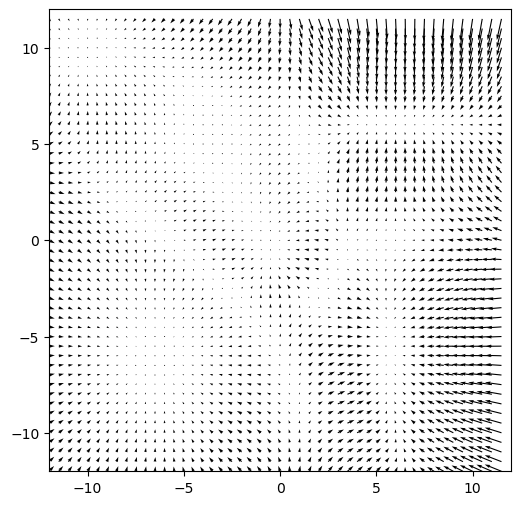

In [58]:
# Creating arrow
grid_x = torch.arange(-12, 12, 0.5)
grid_y = torch.arange(-12, 12, 0.5)
X, Y = torch.meshgrid(grid_x, grid_y)
x_grid = torch.stack([torch.flatten(X), torch.flatten(Y)], dim=1)
with torch.no_grad():
    s = fisher_score_net(x_grid)
# creating plot
fig, ax = plt.subplots(figsize =figsize)
ax.quiver(x_grid[:, 0], x_grid[:, 1], s[:, 0], s[:, 1])
ax.axis([-12, 12, -12, 12])
ax.set_aspect('equal')
# show plot
plt.show()

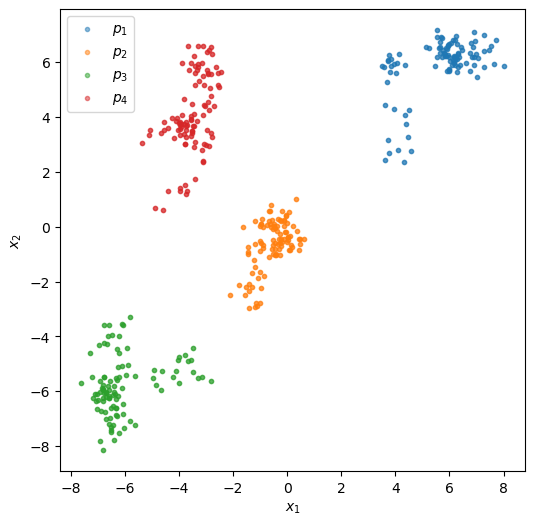

In [59]:
traj_1 = torch.stack(x_traj)[:, 1, :].detach()
traj_2 = torch.stack(x_traj)[:, 2, :].detach()
traj_3 = torch.stack(x_traj)[:, 3, :].detach()
traj_4 = torch.stack(x_traj)[:, 4, :].detach()

plt.figure(figsize=figsize)
plt.scatter(traj_1[:, 0], traj_1[:, 1], marker=".", alpha=0.5, label=r'$p_1$')
plt.scatter(traj_2[:, 0], traj_2[:, 1], marker=".", alpha=0.5, label=r'$p_2$')
plt.scatter(traj_3[:, 0], traj_3[:, 1], marker=".", alpha=0.5, label=r'$p_3$')
plt.scatter(traj_4[:, 0], traj_4[:, 1], marker=".", alpha=0.5, label=r'$p_4$')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

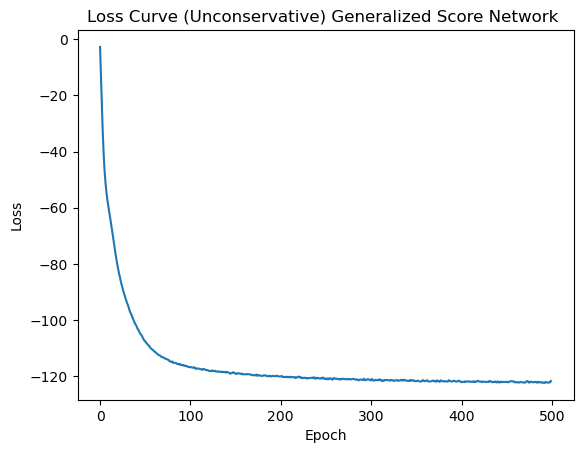

In [130]:
general_score_net = nn.Sequential(nn.Linear(in_dim, hidden_dim),
                        nn.SiLU(), 
                        nn.Linear(hidden_dim, hidden_dim),
                        nn.SiLU(), 
                        nn.Linear(hidden_dim, in_dim),
                        )
optimizer_L = torch.optim.Adam(general_score_net.parameters(), lr=4e-4)

epoch_losses = []
for epoch in tqdm(range(500)):
    epoch_loss = 0.0
    np.random.shuffle(ids)
    split = np.array_split(ids, math.ceil(len(ids) / bs))
    for i, idx in enumerate(split):
        optimizer_L.zero_grad()
        xin = torch_dataset[idx]
        xin.requires_grad_()        
        J, score = compute_model_forward_jacobian(xin, model=general_score_net)  
        scorenorm = score.pow(2).sum(-1).mean()
        lr = L_r(xin, J).mean()
        lphi = L_phi(xin, J).mean()
        srsq = (2 * score[:, 0]).mean()
        loss = scorenorm + 2 * (lr + lphi + srsq)
        loss.backward()
        optimizer_L.step()
        
        epoch_loss += loss.item()
    
    epoch_loss /= len(split)
    
    epoch_losses.append(epoch_loss)
    
plt.plot(figsize=figsize)
plt.plot(range(len(epoch_losses)), epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve (Unconservative) Generalized Score Network ")
plt.show()

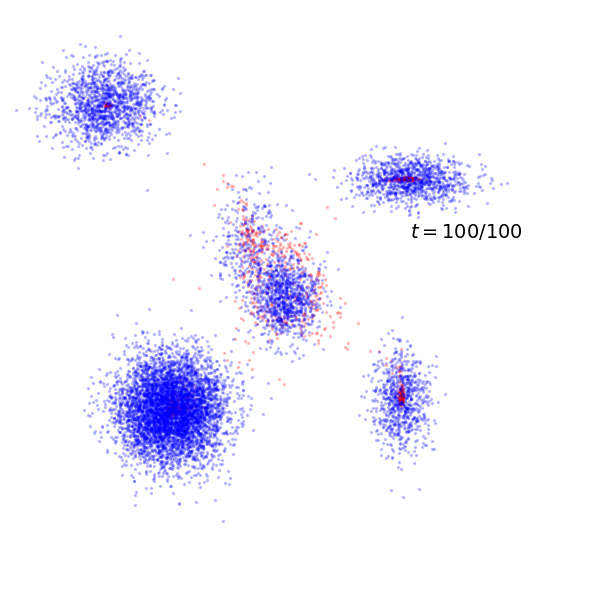

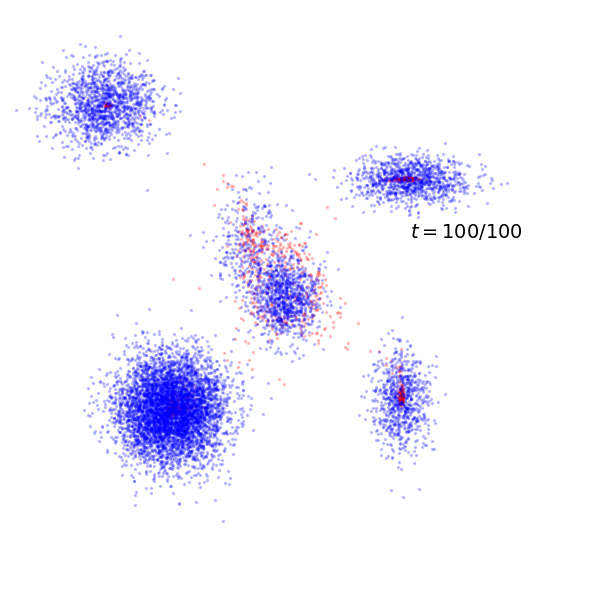

In [139]:
num_samples = 1000
T = 100
chain = np.arange(T)

xsampled = torch.randn(num_samples, in_dim) * 4.0
x_traj = []

xnumpy = x.detach().cpu()
fig, ax = plt.subplots(figsize=figsize)
scatter_plot = ax.scatter(xsampled.detach().cpu()[:, 0],
                          xsampled.detach().cpu()[:, 1],
                          s=2, alpha=0.2, color='red', label="generated")
true_plot = ax.scatter(xnumpy[:, 0],
                      xnumpy[:, 1],
                      s=2, alpha=0.2, color='blue', label="true")

time_text = ax.text(6.0, 3.0, '$t=0$', fontsize=14)
ax.axis('equal')
ax.set_xlim(-15.0, 15.0)
ax.set_ylim(-15.0, 15.0)
ax.axis("off") # remove the axis will speed up the training
fig.tight_layout()
clear_output(wait=True)
display(fig)

# 1e-2 converges faster
eps0 = 1e-3
eps1 = 1e-3

with torch.no_grad():
    for i, t in tqdm(enumerate(chain), total=T):
        score = general_score_net(xsampled)
        # score[:,1] = 0.0
        
        M = torch.stack([eps0 * score, eps0 * score.flip(-1)], dim=-1)
        M[:, 1, 0] = -1.0 * M[:, 1, 0] 
        
        shift = torch.einsum('bij, bj -> bi', (M, xsampled))
    
        xsampled = xsampled + shift + math.sqrt(eps0) * torch.randn_like(xsampled)
        x_traj.append(xsampled)        
        time_text.set_text(f'$t={i+1} / {T}$')
        scatter_plot.set_offsets(xsampled.cpu().detach().numpy())
        x_traj.append(xsampled)
        clear_output(wait=True)
        display(fig)
        plt.savefig('full_dynamics.png')

In [118]:
M

tensor([[[-0.0334, -0.0740],
         [ 0.0740, -0.0334]],

        [[ 0.0760, -0.0754],
         [ 0.0754,  0.0760]],

        [[-0.0378,  0.0424],
         [-0.0424, -0.0378]],

        ...,

        [[-0.0855, -0.0827],
         [ 0.0827, -0.0855]],

        [[ 0.0442, -0.0602],
         [ 0.0602,  0.0442]],

        [[ 0.0576, -0.0408],
         [ 0.0408,  0.0576]]])

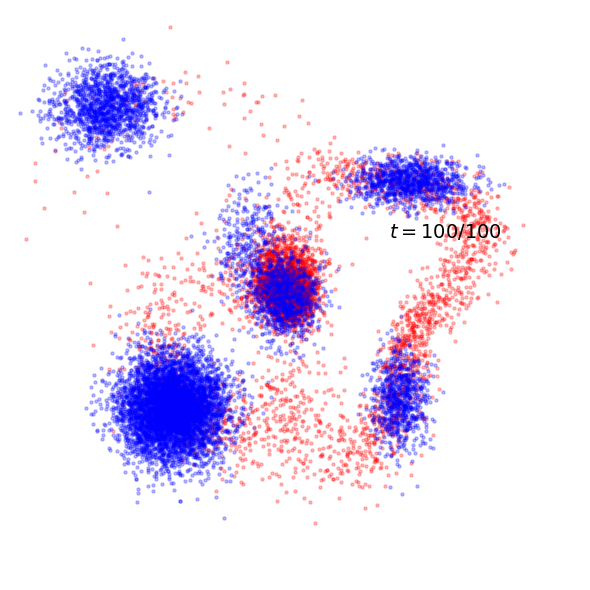

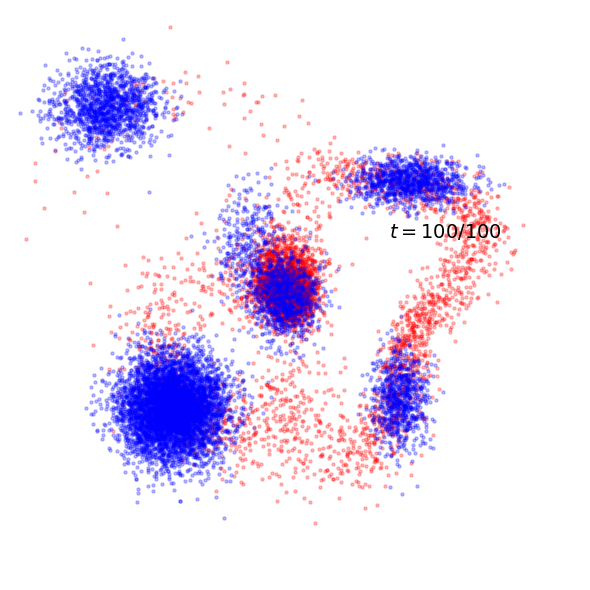

In [174]:
num_samples = 5000
T = 100
chain = np.arange(T)

xsampled = torch.randn(num_samples, in_dim) * 4.0
x_traj = []

xnumpy = x.detach().cpu()
fig, ax = plt.subplots(figsize=figsize)
scatter_plot = ax.scatter(xsampled.detach().cpu()[:, 0],
                          xsampled.detach().cpu()[:, 1],
                          s=5, alpha=0.25, color='red', label="generated")
true_plot = ax.scatter(xnumpy[:, 0],
                      xnumpy[:, 1],
                      s=5, alpha=0.25, color='blue', label="true")


time_text = ax.text(5.0, 3.0, '$t=0$', fontsize=14)
ax.axis('equal')
ax.set_xlim(-15.0, 15.0)
ax.set_ylim(-15.0, 15.0)
ax.axis("off") # remove the axis will speed up the training
fig.tight_layout()
clear_output(wait=True)
display(fig)


# 1e-2 converges faster
eps0 = 5e-3
eps1 = 5e-3

with torch.no_grad():
    for i, t in tqdm(enumerate(chain), total=T):
        score = general_score_net(xsampled)
        score[:,1]=0.0
        M = torch.stack([score, score.flip(-1)], dim=-1)
        M[:, 1, 0] = -1.0 * M[:, 1, 0] 
        Z = torch.randn_like(xsampled)
        Z = torch.stack([Z, Z.flip(-1)], dim=-1)
        Z[:, 1, 0] = -1.0 * Z[:, 1, 0] 
        M = eps0 * M + math.sqrt(eps0) * Z
        shift = torch.einsum('bij, bj -> bi', (M, xsampled))
        xsampled = xsampled + shift
        
        x_traj.append(xsampled)        
        time_text.set_text(f'$t={i+1} / {T}$')
        scatter_plot.set_offsets(xsampled.cpu().detach().numpy())
        x_traj.append(xsampled)
        clear_output(wait=True)
        display(fig)
        plt.savefig('radial_dynamics3.png')

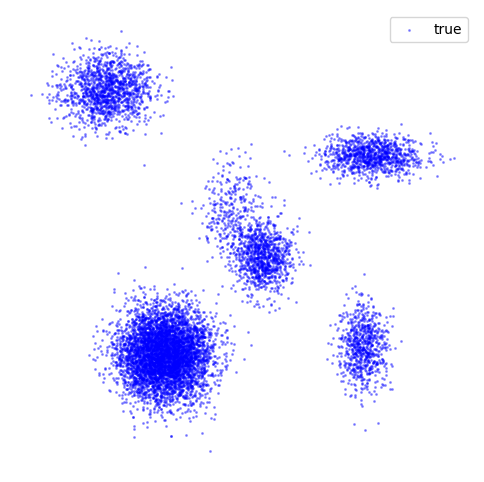

In [172]:
xsampled = xsampled.detach().cpu()
x = x.detach().cpu()
plt.figure(figsize=figsize)
plt.scatter(x[:, 0].numpy(), x[:, 1].numpy(), marker=".", color="blue", label="true", s=5, alpha=0.35)
# plt.scatter(xsampled[:, 0].numpy(), xsampled[:, 1].numpy(), marker=".", color="red", label="generated", s=3, alpha=0.4)
plt.xticks([])
plt.yticks([])
# plt.xlabel('$x_1$')
# plt.ylabel('$x_2$')
plt.legend()
ax.set_frame_on(False)  # Remove the frame
plt.axis('off')  # Turn off the axis
plt.savefig('angular_dyn.png')
plt.show()

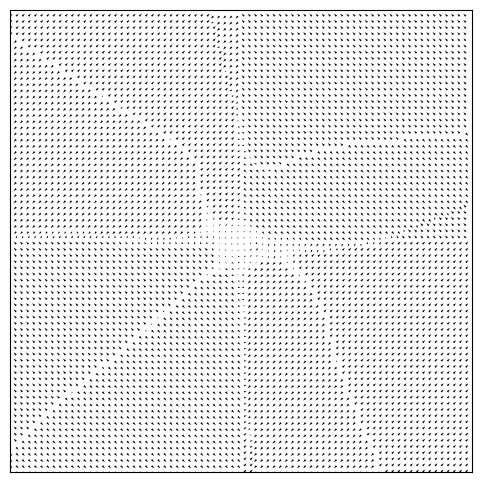

In [148]:
# Creating arrow
grid_x = torch.arange(-15, 15, 0.4)
grid_y = torch.arange(-15, 15, 0.4)
X, Y = torch.meshgrid(grid_x, grid_y)
x_grid = torch.stack([torch.flatten(X), torch.flatten(Y)], dim=1)
with torch.no_grad():
    s = general_score_net(x_grid)
# creating plot
# sr = torch.mul(torch.stack([s[:, 1], s[:, 1]],).T, x_grid)
x_grid2 = torch.stack([-torch.flatten(Y), torch.flatten(X)], dim=1)
s2 = torch.clamp((torch.mul(torch.stack([s[:, 1], s[:, 1]],).T, x_grid2).T ).T, min=-1, max=1)
fig, ax = plt.subplots(figsize =figsize)
# ax.quiver(x_grid[:, 0], x_grid[:, 1], sr[:, 0], sr[:, 1])
ax.quiver(x_grid[:, 0], x_grid[:, 1], s2[:, 0], s2[:, 1])
ax.axis([-15, 15, -15, 15])
ax.set_aspect('equal')
# show plot
plt.xticks([])
plt.yticks([])
# plt.savefig('angular_vector_field.png')
plt.show()

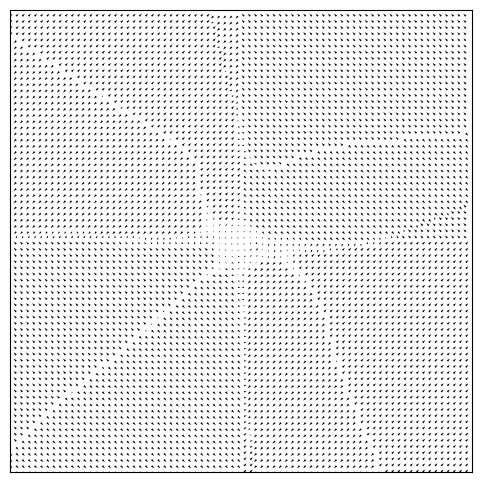

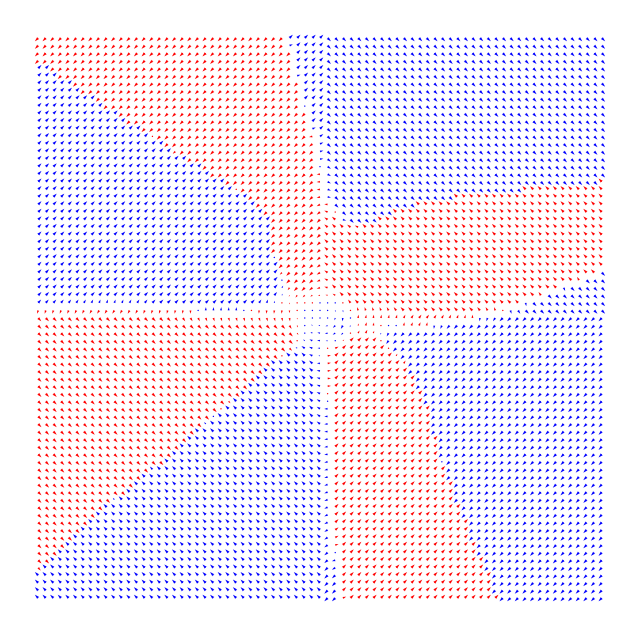

In [165]:
grid_x = torch.arange(-15, 15, 0.4)
grid_y = torch.arange(-15, 15, 0.4)
X, Y = torch.meshgrid(grid_x, grid_y)
x_grid = torch.stack([torch.flatten(X), torch.flatten(Y)], dim=1)
with torch.no_grad():
    s = general_score_net(x_grid)
# creating plot
# sr = torch.mul(torch.stack([s[:, 1], s[:, 1]],).T, x_grid)
x_grid2 = torch.stack([-torch.flatten(Y), torch.flatten(X)], dim=1)
s2 = torch.clamp((torch.mul(torch.stack([s[:, 1], s[:, 1]],).T, x_grid2).T ).T, min=-1, max=1)
fig, ax = plt.subplots(figsize =figsize)
# ax.quiver(x_grid[:, 0], x_grid[:, 1], sr[:, 0], sr[:, 1])
ax.quiver(x_grid[:, 0], x_grid[:, 1], s2[:, 0], s2[:, 1])
ax.axis([-15, 15, -15, 15])
ax.set_aspect('equal')
# show plot
plt.xticks([])
plt.yticks([])
# plt.savefig('angular_vector_field.png')
plt.show()

r_vectors = x_grid

# Calculate the cross product between sr and r_vectors to determine clockwise/counterclockwise
# In 2D, cross product is equivalent to the determinant of a 2x2 matrix formed by the vectors
cross_product = s2[:, 0] * r_vectors[:, 1] - s2[:, 1] * r_vectors[:, 0]

# Define a colormap for clockwise (negative cross product) and counterclockwise (positive cross product)
colors = np.where(cross_product > 0, 'red', 'blue')  # Green for counterclockwise, orange for clockwise

# Plot the vector field with color-coded arrows
fig, ax = plt.subplots(figsize=(8, 8))
ax.quiver(x_grid[:, 0], x_grid[:, 1], -s2[:, 0], -s2[:, 1], color=colors)

# Remove the border, axis, and ticks
ax.set_frame_on(False)  # Remove the frame
plt.axis('off')  # Turn off the axis

# Save the figure and show the plot
plt.savefig('angular_vector_field.png', bbox_inches='tight', pad_inches=0)
plt.show()

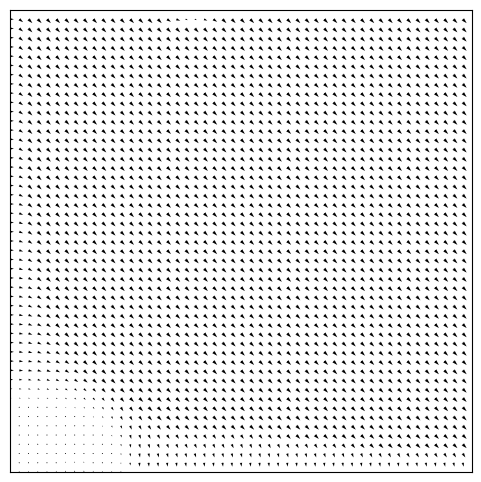

In [109]:
# Creating arrow
grid_x = torch.arange(0, 5, 0.1)
grid_y = torch.arange(0, 5, 0.1)
X, Y = torch.meshgrid(grid_x, grid_y)
x_grid = torch.stack([torch.flatten(X), torch.flatten(Y)], dim=1)
with torch.no_grad():
    s = general_score_net(x_grid)
# creating plot
# sr = torch.mul(torch.stack([s[:, 1], s[:, 1]],).T, x_grid)
x_grid2 = torch.stack([-torch.flatten(Y), torch.flatten(X)], dim=1)
s2 = torch.clamp((torch.mul(torch.stack([s[:, 0], s[:, 1]],).T, x_grid2).T ).T, min=-1, max=1)
fig, ax = plt.subplots(figsize =figsize)
# ax.quiver(x_grid[:, 0], x_grid[:, 1], sr[:, 0], sr[:, 1])
ax.quiver(x_grid[:, 0], x_grid[:, 1], s2[:, 0], s2[:, 1])
ax.axis([0, 5, 0, 5])
ax.set_aspect('equal')
# show plot
plt.xticks([])
plt.yticks([])
plt.show()

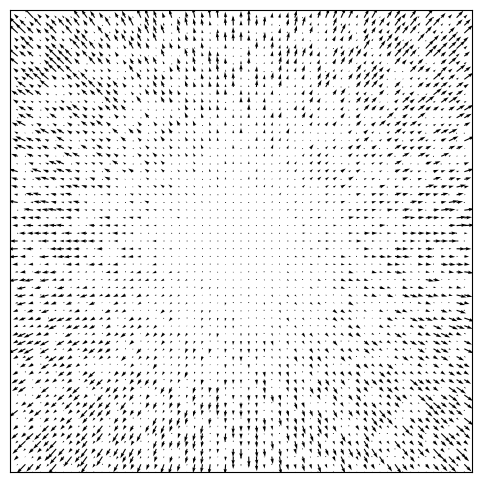

In [127]:
# Creating arrow
grid_x = torch.arange(-15, 15, 0.5)
grid_y = torch.arange(-15, 15, 0.5)
X, Y = torch.meshgrid(grid_x, grid_y)
x_grid = torch.stack([torch.flatten(X), torch.flatten(Y)], dim=1)
with torch.no_grad():
    s = general_score_net(x_grid)
# creating plot
sr =- torch.mul(torch.stack([s[:, 0], s[:, 0]],).T, x_grid)
#x_grid2 = torch.stack([-torch.flatten(Y), torch.flatten(X)], dim=1)
#s2 = torch.clamp((torch.mul(torch.stack([s[:, 1], s[:, 1]],).T, x_grid2).T ).T, min=-1, max=1)
fig, ax = plt.subplots(figsize =figsize)
ax.quiver(x_grid[:, 0], x_grid[:, 1], -sr[:, 0], -sr[:, 1])
#ax.quiver(x_grid[:, 0], x_grid[:, 1], s2[:, 0], s2[:, 1])
ax.axis([-15, 15, -15, 15])
ax.set_aspect('equal')
# show plot
plt.xticks([])
plt.yticks([])
plt.savefig('radial_vector_field.png')
plt.show()

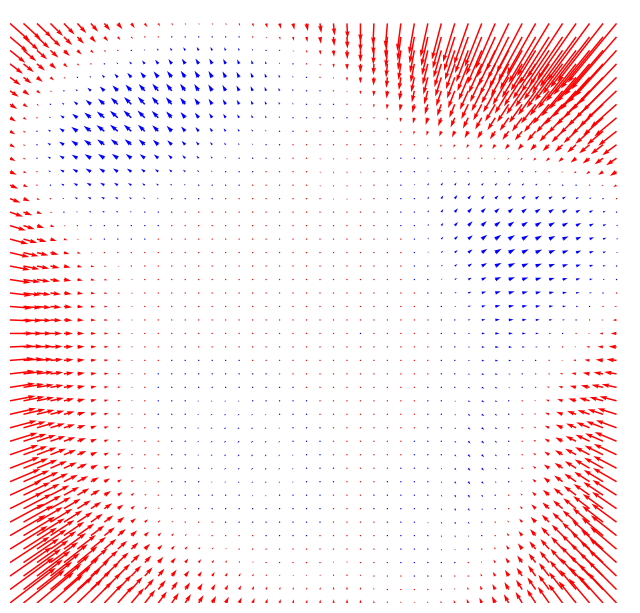

In [161]:
# Creating arrow
grid_x = torch.arange(-13, 10, 0.5)
grid_y = torch.arange(-10, 12, 0.5)
X, Y = torch.meshgrid(grid_x, grid_y)
x_grid = torch.stack([torch.flatten(X), torch.flatten(Y)], dim=1)
with torch.no_grad():
    s = general_score_net(x_grid)

# Calculate the radial vectors (from the origin)
r_vectors = x_grid

# Calculate the score vectors based on your model's output
sr = -torch.mul(torch.stack([s[:, 0], s[:, 0]],).T, x_grid)

# Calculate the dot product of sr with r_vectors to determine inward/outward
dot_product = torch.sum(sr * r_vectors, dim=1)

# Define a colormap for inward/outward
colors = np.where(dot_product > 0, 'red', 'blue')  # Red for outward, blue for inward

# Plot the vector field with color-coded arrows
fig, ax = plt.subplots(figsize=(8, 8))
ax.quiver(x_grid[:, 0], x_grid[:, 1], -sr[:, 0], -sr[:, 1], color=colors)
ax.axis([-13, 10, -10, 12])
ax.set_aspect('equal')
ax.set_frame_on(False)

# Remove ticks for a cleaner look
plt.xticks([])
plt.yticks([])

# Save the figure and show the plot
plt.savefig('radial_vector_field.png')
plt.show()
